# Ride-Sharing Factors Affecting Number of Trips

You're working as an analyst for Zuber, a new ride-sharing company that's launching in Chicago. Your task is to find patterns in the available information. You want to understand passenger preferences and the impact of external factors on rides.

Working with a database, you'll analyze data from competitors and test a hypothesis about the impact of weather on ride frequency.

The purpose of this project is to find patterns in competitior's data to determine how to best utilize passenger preferences and plan for external factors to maximize the total number of trips Zuber can plan for.

First, I will load in and observe data from two datasets (checking trips per company and trips per dropoff location), then I will perform data preprocessing to clean up each column as needed. I'll identify the top dropoff locations in Chicago. Then, I will look at data on the Loop to O'Hare International Airport and test if weather conditions affect the ride duration.

## Initialization

In [1]:
# import libraries
import pandas as pd
from scipy import stats as st

### Loading Datasets

In [2]:
# loading datasets 
try:
    companies = pd.read_csv('/datasets/project_sql_result_01.csv')
    dropoffs = pd.read_csv('/datasets/project_sql_result_04.csv')
    airport = pd.read_csv('/datasets/project_sql_result_07.csv')
except:
    print("One or more of the data files could not be read.")

## Preprocessing Data

### Companies

This dataset contains two fields - the taxi company name and the number of rides each taxi company had between November 15, 2017 and November 16, 2017.

In [3]:
# checking basic info
companies.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 64 entries, 0 to 63
Data columns (total 2 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   company_name  64 non-null     object
 1   trips_amount  64 non-null     int64 
dtypes: int64(1), object(1)
memory usage: 1.1+ KB


In [4]:
# checking first 10 rows
companies.head(10)

,company_name,trips_amount
0,Flash Cab,19558
1,Taxi Affiliation Services,11422
2,Medallion Leasing,10367
3,Yellow Cab,9888
4,Taxi Affiliation Service Yellow,9299
5,Chicago Carriage Cab Corp,9181
6,City Service,8448
7,Sun Taxi,7701
8,Star North Management LLC,7455
9,Blue Ribbon Taxi Association Inc.,5953


This dataset looks good - there are no null values and the data types for each column look fine.

### Dropoffs

This dataset contains two columns - the dropoff location, which are Chicago neighborhoods where rides ended, and and the average number of trips in November for each location.

In [5]:
# checking basic info
dropoffs.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 94 entries, 0 to 93
Data columns (total 2 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   dropoff_location_name  94 non-null     object 
 1   average_trips          94 non-null     float64
dtypes: float64(1), object(1)
memory usage: 1.6+ KB


In [6]:
# checking first 10 rows
dropoffs.head(10)

,dropoff_location_name,average_trips
0,Loop,10727.466667
1,River North,9523.666667
2,Streeterville,6664.666667
3,West Loop,5163.666667
4,O'Hare,2546.900000
5,Lake View,2420.966667
6,Grant Park,2068.533333
7,Museum Campus,1510.000000
8,Gold Coast,1364.233333
9,Sheffield & DePaul,1259.766667


There are no null values for this dataset, but the average number of trips is a floating point value when we need it to be an interger. I will convert this column to the proper data type.

In [7]:
# convert average_trips column to integer
dropoffs['average_trips'] = dropoffs['average_trips'].astype('int')

# check that data has been updated
dropoffs.head(5)

,dropoff_location_name,average_trips
0,Loop,10727
1,River North,9523
2,Streeterville,6664
3,West Loop,5163
4,O'Hare,2546


### Airports

This dataset contains three columns: The pickup time of a ride, the weather condition at the time, and the ride duration in seconds. This data is on rides from the Loop to O'Hare International Airport.

In [8]:
# checking basic info
airport.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1068 entries, 0 to 1067
Data columns (total 3 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   start_ts            1068 non-null   object 
 1   weather_conditions  1068 non-null   object 
 2   duration_seconds    1068 non-null   float64
dtypes: float64(1), object(2)
memory usage: 25.2+ KB


In [9]:
# checking first 10 rows
airport.head(10)

,start_ts,weather_conditions,duration_seconds
0,2017-11-25 16:00:00,Good,2410.0
1,2017-11-25 14:00:00,Good,1920.0
2,2017-11-25 12:00:00,Good,1543.0
3,2017-11-04 10:00:00,Good,2512.0
4,2017-11-11 07:00:00,Good,1440.0
5,2017-11-11 04:00:00,Good,1320.0
6,2017-11-04 16:00:00,Bad,2969.0
7,2017-11-18 11:00:00,Good,2280.0
8,2017-11-11 14:00:00,Good,2460.0
9,2017-11-11 12:00:00,Good,2040.0


There are no null values in this dataset, but `start_ts` can be converted to a datetime format and `duration_seconds` can be converted to an integer type.

In [10]:
# convert columns
airport['start_ts'] = pd.to_datetime(airport['start_ts'], format = '%Y-%m-%d %H:%M:%S')
airport['duration_seconds'] = airport['duration_seconds'].astype('int')

# check that data has been updated
airport.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1068 entries, 0 to 1067
Data columns (total 3 columns):
 #   Column              Non-Null Count  Dtype         
---  ------              --------------  -----         
 0   start_ts            1068 non-null   datetime64[ns]
 1   weather_conditions  1068 non-null   object        
 2   duration_seconds    1068 non-null   int64         
dtypes: datetime64[ns](1), int64(1), object(1)
memory usage: 25.2+ KB


The data has been cleaned up. There were no null values, and we did not drop any rows. For two columns (`duration_seconds` in the airport dataset and `average_trips` in the dropoffs dataset), the data type was converted from a float to an integer.

## Exploratory Data Analysis

Now that the datasets have been cleaned, I will use the first two datasets to find information about the most popular dropoff neighborhoods and the most popular taxi companies in Chicago. 

### Top Neighborhoods

In [11]:
# check basic information on dropoffs dataset
dropoffs.describe()

,average_trips
count,94.000000
mean,599.478723
std,1714.555974
min,1.000000
25%,14.000000
50%,51.500000
75%,298.750000
max,10727.000000


There are 94 neighborhoods in our dataset with an average of about 600 trips. Some neighborhoods have a significantly larger amount of trips than others. We will only look at the top 10 neighborhoods.

In [12]:
# view the 10 neighborhoods with the most dropoffs
top_dropoffs = dropoffs.sort_values(by=['average_trips'], ascending=False).head(10)
top_dropoffs

,dropoff_location_name,average_trips
0,Loop,10727
1,River North,9523
2,Streeterville,6664
3,West Loop,5163
4,O'Hare,2546
5,Lake View,2420
6,Grant Park,2068
7,Museum Campus,1510
8,Gold Coast,1364
9,Sheffield & DePaul,1259


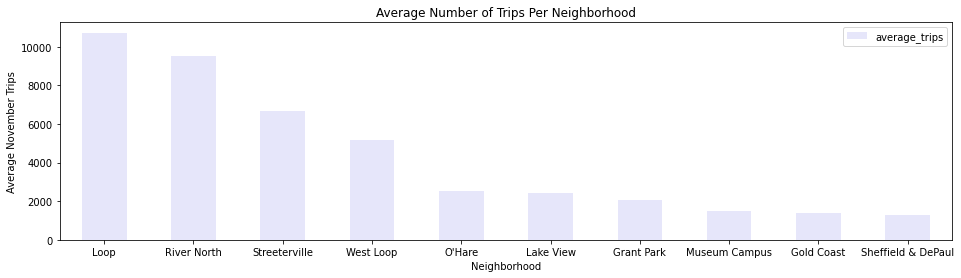

In [13]:
top_dropoffs.plot(
    kind = 'bar',
    x = 'dropoff_location_name',
    rot = 0,
    xlabel = 'Neighborhood',
    ylabel = 'Average November Trips',
    title = 'Average Number of Trips Per Neighborhood',
    color = 'lavender',
    figsize = (16, 4));

Of the 94 neighborhoods, the 10 neighborhoods above have the most amount of trips. Of these 10, Loop, River North, Streeterville, and West Loop are the most popular; West Loop has approximately double the amount of trips as the next highest neighborhood, O'Hare.

<div class="alert alert-block alert-success">
<b>Success:</b> Great visualization!
</div>

### Companies vs Rides

In [14]:
# checking basic information about the companies dataset
companies.describe()

,trips_amount
count,64.000000
mean,2145.484375
std,3812.310186
min,2.000000
25%,20.750000
50%,178.500000
75%,2106.500000
max,19558.000000


There are 64 companies included in this dataset. Like the dropoffs dataset, there is a lot of variability in terms of how many rides each company had during November. We only want to look at our top competitors, so we will filter out the companies where their number of trips is under the third quartile.

In [15]:
# get q3 of trips
trip_q3 = companies['trips_amount'].quantile(0.75)

# get top companies
top_companies = companies.query('trips_amount > @trip_q3')

# show top companies
top_companies

,company_name,trips_amount
0,Flash Cab,19558
1,Taxi Affiliation Services,11422
2,Medallion Leasing,10367
3,Yellow Cab,9888
4,Taxi Affiliation Service Yellow,9299
5,Chicago Carriage Cab Corp,9181
6,City Service,8448
7,Sun Taxi,7701
8,Star North Management LLC,7455
9,Blue Ribbon Taxi Association Inc.,5953


The top 15 companies are the ones that are above the quartile 3 margin.

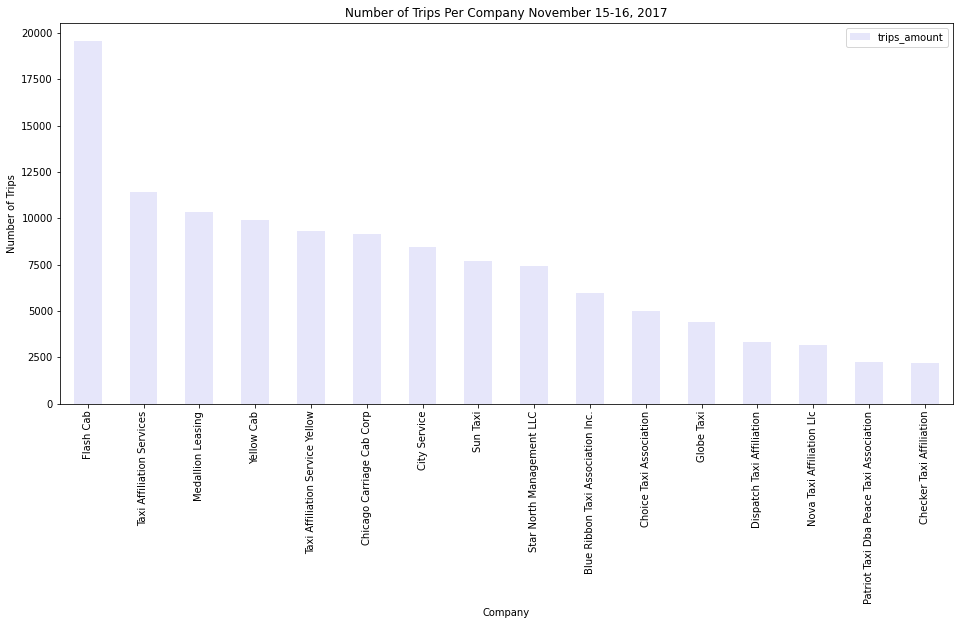

In [16]:
# plot the top companies
top_companies.plot(
    kind = 'bar',
    x = 'company_name',
    xlabel = 'Company',
    ylabel = 'Number of Trips',
    title = 'Number of Trips Per Company November 15-16, 2017',
    color = 'lavender',
    figsize = (16, 7));

Flash Cab had the highest number of trips between November 15-16, 2017 and has nearly double the amount of trips as the company in second place, the Taxi Affiliation Services. Though there are 64 total taxi companies in Chicago, it appears that the top 10 companies are so are the ones who have the most amount of rides.

## Hypothesis Testing

Next, I will take a closer look at the airport dataset, which contains data on the rides from the Loop to O'Hare International Airport. This dataset contains information on what time the ride started, what the weather was like at the start of the ride, and how long the ride lasted.

I want to determine if the average duration of rides from the Loop to O'Hare International Airport changes on rainy Saturdays.

The null hypothesis is that the average duration of rides from the Loop to O'Hare International Airport does not change if the weather is poor. The alternative hypothesis is that the average duration of rides does change.

An alpha value of 0.5 will be used. I will be using a Independent Samples T-Test since we want to compare the means of two groups (being when weather conditions are good versus when they are bad).

In [17]:
# creating dataframes to compare
good_weather = airport.query('weather_conditions == "Good"')
bad_weather = airport.query('weather_conditions == "Bad"')

In [18]:
# check variances
print(f'Good Weather Conditions Duration Variation: {good_weather.duration_seconds.var()}')
print(f'Bad Weather Conditions Duration Variation: {bad_weather.duration_seconds.var()}')

Good Weather Conditions Duration Variation: 576382.009689509
Bad Weather Conditions Duration Variation: 520294.086002483


The variances are about equal.

In [19]:
# test the hypotheses
results = st.ttest_ind(good_weather.duration_seconds, bad_weather.duration_seconds, equal_var = True)
print(f'p-value: {results.pvalue}')

p-value: 6.517970327099473e-12


The p-value is significantly smaller than our alpha of 0.05, so our p-value is statistically significant. We can reject our null hypothesis and say that it is likely that the average duration of rides from the Loop to O'Hare International Airport indeed is affected if the weather is bad.

## Conclusion

In this project, I observed three different datasets. I first cleaned them by updating the column data types to the appropriate type. Then, I determined the top 10 neighborhoods that riders are dropped off at the most and observed the taxi companies that have the largest amount of rides. Loop, River North, Streeterville, and West Loop were found to be the most popular dropoff locations, the Flash Cab was found to be the most successful taxi company in terms of number of rides.

Finally, I used a T-Test to determine if poor weather affects the average duration of rides from the Loop to O'Hare International Airport. We rejected the null hypothesis and detemined that poor weather has an affect on average duration of rides.